In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import seaborn as sns
from operator import add

In [2]:
spark = SparkSession \
    .builder \
    .appName("Spark_Processor") \
    .master("local[*]") \
    .getOrCreate()

sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/09 17:23:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
data_df = spark.read.csv('MDA2022ProjectData.csv', header=True).sample(fraction=0.1)
data_df = data_df.filter(data_df['ORIGINE_CAR_KEY'] == data_df['FINAL_CAR_KEY'])
data_df.show(10)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|   22010047|      284|       63479234|     63479234|               6|       161|2021-12-22 00:48:53|
|   22010043|      284|       63181203|     63181203|               6|       161|2021-12-22 00:36:47|
|   22010079|      284|       63348486|     63348486|               6|       161|2021-12-22 01:14:32|
|   22010048|      284|       63304612|     63304612|               6|       161|2021-12-22 00:57:17|
|   22010112|      284|       63540629|     63540629|               6|       264|2021-12-22 01:23:27|
|   22010043|      284|       35157216|     35157216|               6|       161|2021-12-22 01:39:21|
|   22010040|      284|       36917809|     36917809|               6|       161|2

In [4]:
# convert data to rdd format
raw_data_rdd = data_df.rdd.map(lambda x: (x['DEVICE_CODE'], x['ORIGINE_CAR_KEY'], x['PASS_DAY_TIME']))

In [5]:
# take only the hour of PASS_DAY_TIME
data_rdd = raw_data_rdd.map(lambda x: (x[0], x[1], x[2].split(' ')[1]))
data_rdd = data_rdd.map(lambda x: (x[0], x[1], x[2].split(':')[0]))

In [6]:
# count the number of cars that have passed each camera by hour
def count(row):
    return (row[0], int(row[2])), 1
camera_hour_count = data_rdd.map(count).reduceByKey(add)

In [7]:
# show the result
camera_hour_count.map(lambda x: (*x[0], x[1])).toDF(schema=['DEVICE_CODE', 'PASS_HOUR', 'COUNT']).show(20)

+-----------+---------+-----+
|DEVICE_CODE|PASS_HOUR|COUNT|
+-----------+---------+-----+
|        155|        0|  715|
|     205202|        0|  795|
|     900239|        0|  752|
|        120|        0|   38|
|  100700943|        0|   46|
|  100700804|        2|  607|
|     900234|        2| 1127|
|     900225|        3|  343|
|     900242|        2|  378|
|     631346|        1|  262|
|     900144|        3|   14|
|     900142|        3|  885|
|     900150|        2|  215|
|     900148|        1|   26|
|   22010054|        5| 1769|
|  100700836|        3|   64|
|     900272|        5|  305|
|     230106|        4|   63|
|     900102|        4|  186|
|     900232|        5|  129|
+-----------+---------+-----+
only showing top 20 rows



In [8]:
# now we create an rdd which contaons a feature vector for each camera
# the features are hours in a day and their value is the number of detected cars
def create_feature_vec(row):
    device_code = row[0]
    feature_vec = np.zeros((24, ))
    for record in row[1]:
        index = int(record[0][1])
        value = record[1]
        feature_vec[index] = value
    feature_vec = Vectors.dense(feature_vec)
    return (device_code, feature_vec)

camera_feature_vec = camera_hour_count.groupBy(lambda x: x[0][0]).mapValues(list).map(create_feature_vec)

In [9]:
camera_feature_vec.toDF(schema=['DEVICE_CODE', 'FEATURE_VEC']).show(20)

+-----------+--------------------+
|DEVICE_CODE|         FEATURE_VEC|
+-----------+--------------------+
|   22010054|[1302.0,758.0,416...|
|     107301|[435.0,307.0,170....|
|     200301|[397.0,212.0,96.0...|
|   22010135|[167.0,110.0,87.0...|
|    1001031|[8.0,6.0,3.0,3.0,...|
|     210110|[6.0,4.0,6.0,7.0,...|
|   22010139|[270.0,324.0,249....|
|     710101|[2.0,1.0,1.0,2.0,...|
|     631929|[5.0,1.0,1.0,4.0,...|
|     900212|[6844.0,3753.0,19...|
|    1001051|[2.0,2.0,1.0,3.0,...|
|     207701|[6.0,1.0,3.0,1.0,...|
|        128|[0.0,0.0,0.0,0.0,...|
|   22009802|[1.0,3.0,4.0,2.0,...|
|        103|[160.0,92.0,34.0,...|
|     900126|[267.0,145.0,87.0...|
|     203902|[1675.0,892.0,474...|
|     631610|[9.0,3.0,3.0,0.0,...|
|     631891|[0.0,0.0,0.0,0.0,...|
|   22009834|[33.0,6.0,10.0,6....|
+-----------+--------------------+
only showing top 20 rows



In [10]:
# perform pca on the data
camera_feature_df = spark.createDataFrame(camera_feature_vec, ['DEVICE_CODE', 'feature_vec'])
dim = 2   # good for visualization
pca = PCA(k=dim, inputCol='feature_vec')
pca.setOutputCol('reduced_feature_vec')
model = pca.fit(camera_feature_df)

23/02/09 17:25:24 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/02/09 17:25:24 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [11]:
# show the pca results
camera_pca = model.transform(camera_feature_df)
camera_pca.show(20)

+-----------+--------------------+--------------------+
|DEVICE_CODE|         feature_vec| reduced_feature_vec|
+-----------+--------------------+--------------------+
|   22010054|[1302.0,758.0,416...|[-13060.650312009...|
|     107301|[435.0,307.0,170....|[-2100.3610658532...|
|     200301|[397.0,212.0,96.0...|[-4585.2098928953...|
|   22010135|[167.0,110.0,87.0...|[-1286.9896280502...|
|    1001031|[8.0,6.0,3.0,3.0,...|[-29.845326107283...|
|     210110|[6.0,4.0,6.0,7.0,...|[-3.4161668013355...|
|   22010139|[270.0,324.0,249....|[-1879.5721151562...|
|     710101|[2.0,1.0,1.0,2.0,...|[-6.8623194327505...|
|     631929|[5.0,1.0,1.0,4.0,...|[-34.060699659742...|
|     900212|[6844.0,3753.0,19...|[-57092.806501184...|
|    1001051|[2.0,2.0,1.0,3.0,...|[-22.272090893339...|
|     207701|[6.0,1.0,3.0,1.0,...|[-54.222304040916...|
|        128|[0.0,0.0,0.0,0.0,...|[-2716.5988239707...|
|   22009802|[1.0,3.0,4.0,2.0,...|[-10.366629946907...|
|        103|[160.0,92.0,34.0,...|[-1756.8509591

In [12]:
# now we apply k-means to data in order to classify cameras into different groups(clusters)
k = 5
kmeans = KMeans(k=k, featuresCol='reduced_feature_vec', predictionCol='cluster')
model = kmeans.fit(camera_pca)

In [13]:
sample_size = 5000
samples = camera_pca.rdd.take(sample_size)

In [14]:
samples_coordinates_list = [x.reduced_feature_vec.toArray().reshape(1, -1) for x in samples]
samples_coordinates = np.concatenate(samples_coordinates_list, axis=0)
samples_clusters = np.array([model.predict(x.reduced_feature_vec) for x in samples])

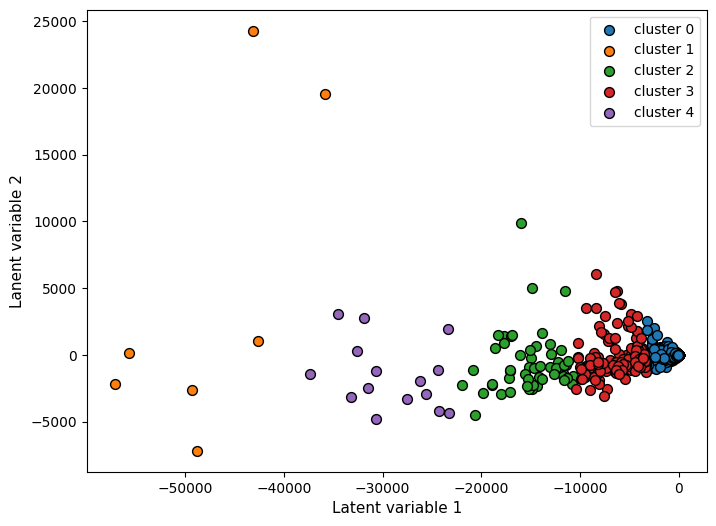

In [15]:
# Visualize the data
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

for i in range(k):
    indices = samples_clusters == i
    ax.scatter(
        samples_coordinates[indices, 0],
        samples_coordinates[indices, 1],
        label=f'cluster {i}',
        edgecolor='black',
        s=50
    )

    
plt.xlabel('Latent variable 1', fontsize=11)
plt.ylabel('Lanent variable 2', fontsize=11)
plt.legend()
plt.show()